# Notebook 6: Classical Models for Anomaly Detection

**Purpose**: Train and evaluate classical ML models for anomaly detection.

**Models**:
1. SVM (Linear)
2. SVM (RBF)
3. Logistic Regression
4. Random Forest
5. Isolation Forest
6. Gaussian Mixture Model (GMM)
7. Classical Autoencoder
8. Classical MLP

**Outputs**:
- `classical_metrics.csv` → `results/`
- ROC curves → `figures/`

---

In [40]:
# Imports
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import json
import time
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC, OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Paths
BASE_DIR = Path('.').resolve().parent
FEATURES_DIR = BASE_DIR / 'data' / 'features'
RESULTS_DIR = BASE_DIR / 'results'
MODELS_DIR = BASE_DIR / 'models'
FIGURES_DIR = BASE_DIR / 'figures'

TARGET_COLUMN = 'Class'

print(f"Random Seed: {RANDOM_SEED}")

Random Seed: 42


## 1. Load Data and Parameters

In [41]:
# Load PCA data
train_df = pd.read_csv(FEATURES_DIR / 'pca_train.csv')
test_df = pd.read_csv(FEATURES_DIR / 'pca_test.csv')

X_train = train_df.drop(columns=[TARGET_COLUMN]).values
y_train = train_df[TARGET_COLUMN].values

X_test = test_df.drop(columns=[TARGET_COLUMN]).values
y_test = test_df[TARGET_COLUMN].values

print(f"Training: {X_train.shape}, Test: {X_test.shape}")
print(f"Train class dist: {np.bincount(y_train)}")
print(f"Test class dist: {np.bincount(y_test)}")

Training: (1600, 10), Test: (400, 10)
Train class dist: [1520   80]
Test class dist: [380  20]


In [42]:
# Default parameters (skip Notebook 5 tuning)
classical_params = {
    'SVM_Linear': {'C': 1, 'class_weight': 'balanced'},
    'SVM_RBF': {'C': 1, 'gamma': 'scale', 'class_weight': 'balanced'},
    'Logistic_Regression': {'C': 1, 'class_weight': 'balanced'},
    'Random_Forest': {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'},
    'Isolation_Forest': {'n_estimators': 100, 'contamination': 0.05},
    'GMM': {'n_components': 2, 'covariance_type': 'full'}
}
print("Using default parameters")

Using default parameters


## 2. Define Evaluation Functions

In [43]:
def safe_normalize(arr):
    """Safely normalize array to [0,1] range, handling edge cases."""
    arr = np.asarray(arr, dtype=float)
    min_val, max_val = arr.min(), arr.max()
    if max_val - min_val < 1e-10:  # All values are the same
        return np.full_like(arr, 0.5)
    return (arr - min_val) / (max_val - min_val)

def compute_metrics(y_true, y_pred, y_prob=None):
    """Compute all classification metrics."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0),
        'fpr': fp / (fp + tn) if (fp + tn) > 0 else 0,
        'tpr': tp / (tp + fn) if (tp + fn) > 0 else 0,
    }
    
    if y_prob is not None and not np.any(np.isnan(y_prob)):
        try:
            metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
        except:
            metrics['roc_auc'] = 0.5
    else:
        metrics['roc_auc'] = 0.5
    
    return metrics

def train_and_evaluate(model, name, X_train, y_train, X_test, y_test, is_supervised=True):
    """Train model and compute metrics with timing."""
    print(f"\nTraining {name}...")
    
    # Training
    start_time = time.time()
    if is_supervised:
        model.fit(X_train, y_train)
    else:
        model.fit(X_train)
    train_time = time.time() - start_time
    
    # Inference
    start_time = time.time()
    if is_supervised:
        y_pred = model.predict(X_test)
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, 'decision_function'):
            y_prob = safe_normalize(model.decision_function(X_test))
        else:
            y_prob = None
    else:
        # For unsupervised models
        raw_pred = model.predict(X_test)
        y_pred = (raw_pred == -1).astype(int)  # -1 = anomaly for sklearn
        if hasattr(model, 'score_samples'):
            scores = -model.score_samples(X_test)
            y_prob = safe_normalize(scores)
        elif hasattr(model, 'decision_function'):
            scores = -model.decision_function(X_test)
            y_prob = safe_normalize(scores)
        else:
            y_prob = None
    inference_time = time.time() - start_time
    
    # Compute metrics
    metrics = compute_metrics(y_test, y_pred, y_prob)
    metrics['train_time'] = train_time
    metrics['inference_time'] = inference_time
    metrics['model'] = name
    
    print(f"  F1: {metrics['f1_score']:.4f}, ROC-AUC: {metrics.get('roc_auc', 'N/A')}")
    print(f"  Train time: {train_time:.2f}s, Inference time: {inference_time:.4f}s")
    
    return metrics, y_pred, y_prob

## 3. Train Classical Models

In [44]:
# Store results
all_metrics = []
all_predictions = {}
all_probabilities = {}

In [45]:
# 1. SVM Linear
params = classical_params.get('SVM_Linear', {})
model = SVC(kernel='linear', probability=True, random_state=RANDOM_SEED, **params)
metrics, y_pred, y_prob = train_and_evaluate(model, 'SVM_Linear', X_train, y_train, X_test, y_test)
all_metrics.append(metrics)
all_predictions['SVM_Linear'] = y_pred
all_probabilities['SVM_Linear'] = y_prob
joblib.dump(model, MODELS_DIR / 'svm_linear.pkl')


Training SVM_Linear...
  F1: 0.8571, ROC-AUC: 0.9099342105263157
  Train time: 120.21s, Inference time: 0.0090s


['C:\\Users\\mostr\\OneDrive\\Documents\\GitHub\\Proj\\Anomaly-detection-in-finance-using-QML\\models\\svm_linear.pkl']

In [46]:
# 2. SVM RBF
params = classical_params.get('SVM_RBF', {})
model = SVC(kernel='rbf', probability=True, random_state=RANDOM_SEED, **params)
metrics, y_pred, y_prob = train_and_evaluate(model, 'SVM_RBF', X_train, y_train, X_test, y_test)
all_metrics.append(metrics)
all_predictions['SVM_RBF'] = y_pred
all_probabilities['SVM_RBF'] = y_prob
joblib.dump(model, MODELS_DIR / 'svm_rbf.pkl')


Training SVM_RBF...
  F1: 0.9000, ROC-AUC: 0.9042105263157896
  Train time: 0.39s, Inference time: 0.0658s


['C:\\Users\\mostr\\OneDrive\\Documents\\GitHub\\Proj\\Anomaly-detection-in-finance-using-QML\\models\\svm_rbf.pkl']

In [47]:
# 3. Logistic Regression
params = classical_params.get('Logistic_Regression', {})
model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, **params)
metrics, y_pred, y_prob = train_and_evaluate(model, 'Logistic_Regression', X_train, y_train, X_test, y_test)
all_metrics.append(metrics)
all_predictions['Logistic_Regression'] = y_pred
all_probabilities['Logistic_Regression'] = y_prob
joblib.dump(model, MODELS_DIR / 'logistic_regression.pkl')


Training Logistic_Regression...
  F1: 0.7826, ROC-AUC: 0.9113815789473685
  Train time: 0.08s, Inference time: 0.0015s


['C:\\Users\\mostr\\OneDrive\\Documents\\GitHub\\Proj\\Anomaly-detection-in-finance-using-QML\\models\\logistic_regression.pkl']

In [48]:
# 4. Random Forest
params = classical_params.get('Random_Forest', {})
model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=1, **params)
metrics, y_pred, y_prob = train_and_evaluate(model, 'Random_Forest', X_train, y_train, X_test, y_test)
all_metrics.append(metrics)
all_predictions['Random_Forest'] = y_pred
all_probabilities['Random_Forest'] = y_prob
joblib.dump(model, MODELS_DIR / 'random_forest.pkl')


Training Random_Forest...
  F1: 0.9474, ROC-AUC: 0.9988157894736842
  Train time: 0.50s, Inference time: 0.0272s


['C:\\Users\\mostr\\OneDrive\\Documents\\GitHub\\Proj\\Anomaly-detection-in-finance-using-QML\\models\\random_forest.pkl']

In [49]:
# 5. Isolation Forest
params = classical_params.get('Isolation_Forest', {})
model = IsolationForest(random_state=RANDOM_SEED, n_jobs=1, **params)
metrics, y_pred, y_prob = train_and_evaluate(model, 'Isolation_Forest', X_train, y_train, X_test, y_test, is_supervised=False)
all_metrics.append(metrics)
all_predictions['Isolation_Forest'] = y_pred
all_probabilities['Isolation_Forest'] = y_prob
joblib.dump(model, MODELS_DIR / 'isolation_forest.pkl')


Training Isolation_Forest...
  F1: 0.2128, ROC-AUC: 0.8202631578947368
  Train time: 0.19s, Inference time: 0.0213s


['C:\\Users\\mostr\\OneDrive\\Documents\\GitHub\\Proj\\Anomaly-detection-in-finance-using-QML\\models\\isolation_forest.pkl']

In [50]:
# 6. Gaussian Mixture Model
print("\nTraining GMM...")
params = classical_params.get('GMM', {})

start_time = time.time()
gmm = GaussianMixture(random_state=RANDOM_SEED, **params)
gmm.fit(X_train)
train_time = time.time() - start_time

start_time = time.time()
scores = gmm.score_samples(X_test)
threshold = np.percentile(gmm.score_samples(X_train), 5)
y_pred = (scores < threshold).astype(int)
y_prob = safe_normalize(-scores)  # Higher score = lower anomaly probability
inference_time = time.time() - start_time

metrics = compute_metrics(y_test, y_pred, y_prob)
metrics['train_time'] = train_time
metrics['inference_time'] = inference_time
metrics['model'] = 'GMM'

print(f"  F1: {metrics['f1_score']:.4f}, ROC-AUC: {metrics.get('roc_auc', 'N/A')}")

all_metrics.append(metrics)
all_predictions['GMM'] = y_pred
all_probabilities['GMM'] = y_prob
joblib.dump(gmm, MODELS_DIR / 'gmm.pkl')


Training GMM...
  F1: 0.3182, ROC-AUC: 0.8780263157894738


['C:\\Users\\mostr\\OneDrive\\Documents\\GitHub\\Proj\\Anomaly-detection-in-finance-using-QML\\models\\gmm.pkl']

In [51]:
# 7. Classical Autoencoder
print("\nTraining Classical Autoencoder...")
from sklearn.neural_network import MLPRegressor

start_time = time.time()
X_train_normal = X_train[y_train == 0]
autoencoder = MLPRegressor(
    hidden_layer_sizes=(16, 8, 16),
    max_iter=200,
    random_state=RANDOM_SEED,
    early_stopping=True
)
autoencoder.fit(X_train_normal, X_train_normal)
train_time = time.time() - start_time

start_time = time.time()
X_reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean((X_test - X_reconstructed) ** 2, axis=1)
threshold = np.percentile(np.mean((X_train_normal - autoencoder.predict(X_train_normal)) ** 2, axis=1), 95)
y_pred = (reconstruction_error > threshold).astype(int)
y_prob = safe_normalize(reconstruction_error)
inference_time = time.time() - start_time

metrics = compute_metrics(y_test, y_pred, y_prob)
metrics['train_time'] = train_time
metrics['inference_time'] = inference_time
metrics['model'] = 'Classical_Autoencoder'

print(f"  F1: {metrics['f1_score']:.4f}, ROC-AUC: {metrics.get('roc_auc', 'N/A')}")

all_metrics.append(metrics)
all_predictions['Classical_Autoencoder'] = y_pred
all_probabilities['Classical_Autoencoder'] = y_prob
joblib.dump(autoencoder, MODELS_DIR / 'classical_autoencoder.pkl')


Training Classical Autoencoder...
  F1: 0.2979, ROC-AUC: 0.8457894736842105


['C:\\Users\\mostr\\OneDrive\\Documents\\GitHub\\Proj\\Anomaly-detection-in-finance-using-QML\\models\\classical_autoencoder.pkl']

In [52]:
# 8. Classical MLP
model = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    max_iter=200,
    random_state=RANDOM_SEED,
    early_stopping=True
)
metrics, y_pred, y_prob = train_and_evaluate(model, 'Classical_MLP', X_train, y_train, X_test, y_test)
all_metrics.append(metrics)
all_predictions['Classical_MLP'] = y_pred
all_probabilities['Classical_MLP'] = y_prob
joblib.dump(model, MODELS_DIR / 'classical_mlp.pkl')


Training Classical_MLP...
  F1: 0.8333, ROC-AUC: 0.9477631578947369
  Train time: 0.27s, Inference time: 0.0029s


['C:\\Users\\mostr\\OneDrive\\Documents\\GitHub\\Proj\\Anomaly-detection-in-finance-using-QML\\models\\classical_mlp.pkl']

## 4. Save Results

In [53]:
# Create metrics DataFrame
metrics_df = pd.DataFrame(all_metrics)

# Reorder columns
col_order = ['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'fpr', 'tpr', 'train_time', 'inference_time']
extra_cols = [c for c in metrics_df.columns if c not in col_order]
metrics_df = metrics_df[col_order + extra_cols]

# Save
metrics_path = RESULTS_DIR / 'classical_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)

print(f"✅ Saved classical metrics to: {metrics_path}")
print("\nClassical Model Results:")
print(metrics_df.to_string(index=False))

✅ Saved classical metrics to: C:\Users\mostr\OneDrive\Documents\GitHub\Proj\Anomaly-detection-in-finance-using-QML\results\classical_metrics.csv

Classical Model Results:
                model  accuracy  precision  recall  f1_score  roc_auc      fpr  tpr  train_time  inference_time
           SVM_Linear    0.9850   0.818182    0.90  0.857143 0.909934 0.010526 0.90  120.214205        0.009000
              SVM_RBF    0.9900   0.900000    0.90  0.900000 0.904211 0.005263 0.90    0.388940        0.065792
  Logistic_Regression    0.9750   0.692308    0.90  0.782609 0.911382 0.021053 0.90    0.077424        0.001493
        Random_Forest    0.9950   1.000000    0.90  0.947368 0.998816 0.000000 0.90    0.501200        0.027214
     Isolation_Forest    0.9075   0.185185    0.25  0.212766 0.820263 0.057895 0.25    0.191067        0.021284
                  GMM    0.9250   0.291667    0.35  0.318182 0.878026 0.044737 0.35    0.068837        0.009995
Classical_Autoencoder    0.9175   0.259259   

## 5. Visualizations

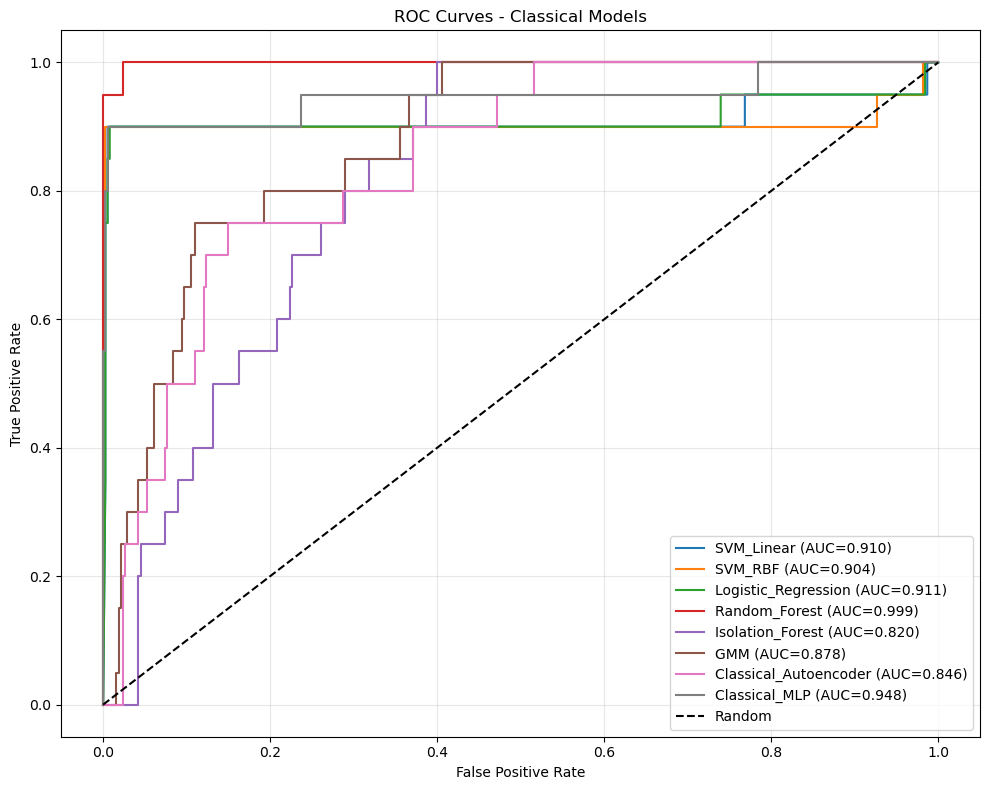

In [54]:
# ROC Curves (with NaN handling)
plt.figure(figsize=(10, 8))

for model_name, y_prob in all_probabilities.items():
    if y_prob is not None and not np.any(np.isnan(y_prob)):
        try:
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc_val = metrics_df[metrics_df['model'] == model_name]['roc_auc'].values[0]
            plt.plot(fpr, tpr, label=f'{model_name} (AUC={auc_val:.3f})')
        except Exception as e:
            print(f"Skipping {model_name} ROC curve: {e}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Classical Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'roc_curves_classical.png', dpi=150)
plt.show()

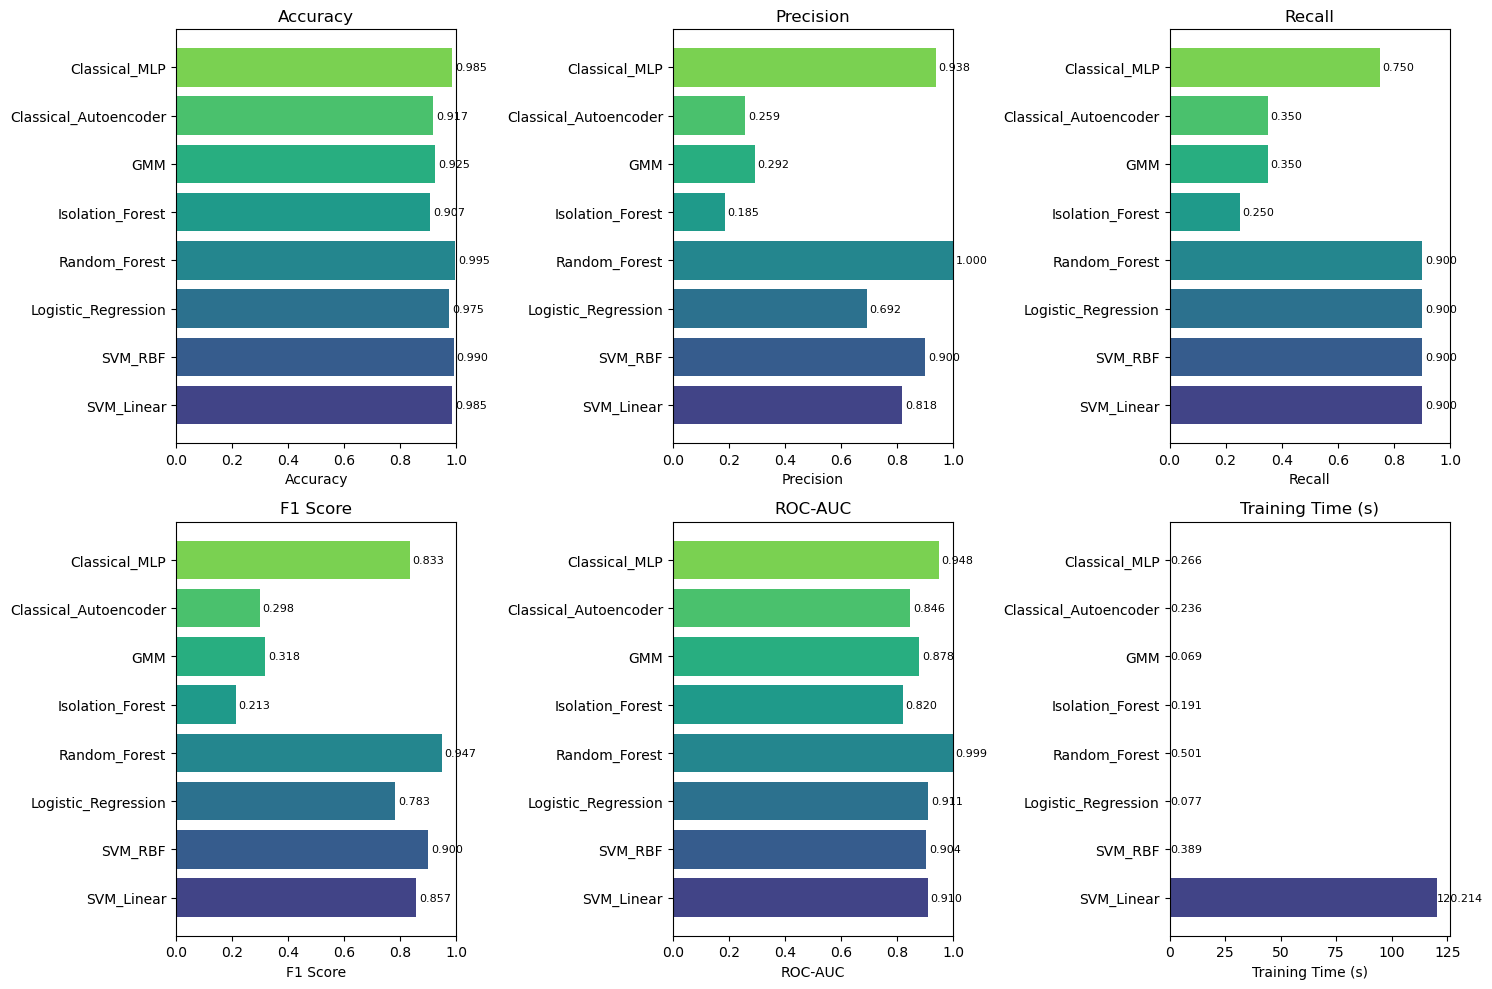

In [55]:
# Metric comparison bar chart
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'train_time']
titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC', 'Training Time (s)']

for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[i]
    values = metrics_df[metric].fillna(0.5).values  # Fill NaN with 0.5 for display
    models = metrics_df['model'].values
    
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(models)))
    bars = ax.barh(models, values, color=colors)
    ax.set_xlabel(title)
    ax.set_title(title)
    
    if metric != 'train_time':
        ax.set_xlim([0, 1])
    
    for bar, val in zip(bars, values):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
               f'{val:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'classical_metrics_comparison.png', dpi=150)
plt.show()

In [56]:
# Summary
print("\n" + "="*50)
print("CLASSICAL MODELS SUMMARY")
print("="*50)
print(f"Total models trained: {len(all_metrics)}")
print(f"\nBest by F1 Score: {metrics_df.loc[metrics_df['f1_score'].idxmax(), 'model']} ({metrics_df['f1_score'].max():.4f})")
print(f"Best by ROC-AUC: {metrics_df.loc[metrics_df['roc_auc'].idxmax(), 'model']} ({metrics_df['roc_auc'].max():.4f})")
print(f"Fastest training: {metrics_df.loc[metrics_df['train_time'].idxmin(), 'model']} ({metrics_df['train_time'].min():.4f}s)")
print("\n✅ Notebook 6 Complete!")


CLASSICAL MODELS SUMMARY
Total models trained: 8

Best by F1 Score: Random_Forest (0.9474)
Best by ROC-AUC: Random_Forest (0.9988)
Fastest training: GMM (0.0688s)

✅ Notebook 6 Complete!
